In [1]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## Rejection Sampling

As a warm-up, let's suppose that we want to sample a pair of random variables (x_1, x_2) drawn uniformly from the unit circle. In other words, we want the uniform distribution over the blue region below:

How can we go about doing this? (Hint: first sample uniformly over the unit square.)

(-1.1, 1.1, -1.0999994488982097, 1.0999994488982097)

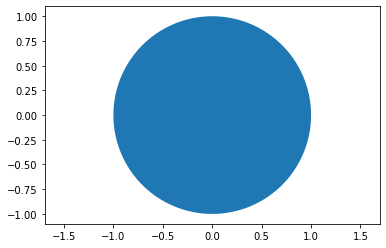

In [4]:
x_ = np.linspace(-1, 1, 1000)
semicircle = np.sqrt(1-x_**2)
plt.fill_between(x_, -semicircle, semicircle)
plt.axis('equal')

Variance of x1 (estimated from samples): 0.246


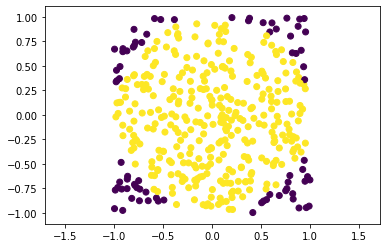

In [6]:
# Number of samples
N = 400

# Samples in the unit square
samples = (np.random.random([N, 2]) - 0.5) * 2

# Which ones are inside the unit circle?
is_in_circle = (samples[:,0]**2 + samples[:, 1]**2) < 1

plt.figure()
plt.scatter(samples[:, 0], samples[:, 1], c=(is_in_circle + 2))
plt.axis('equal')

good_samples = samples[is_in_circle]
x1 = good_samples[:, 0]
x2 = good_samples[:, 1]
print('Variance of x1 (estimated from samples): %.3f' % np.var(x1))

Next, let's think about sampling from a distribution with a complicated density. Suppose we want to sample from the distribution with density $p(x) \propto x \cdot (1.5-x) \cdot \sin(x)$ for $x \in [0,1.5]$:

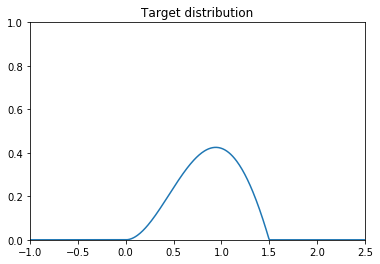

In [7]:
x = np.linspace(-1, 2.5, 500)
def target(x):
    """The unnormalized distribution we want to sample from"""
    return x * (1.5-x) * np.sin(x) * ((x > 0) & (x < 1.5))
plt.plot(x, target(x))
plt.title('Target distribution')
plt.axis([-1,2.5,0,1])
plt.show()

How can we make this look like the geometric example from before? Idea: "lifting" (add one dimension).

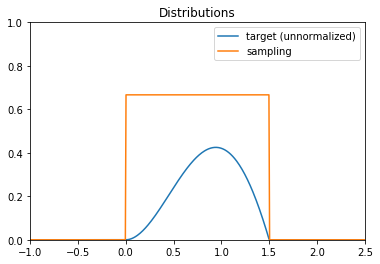

In [23]:
x = np.linspace(-1, 2.5, 500)
def uniform_sampling_dist(x):
    """PDF of distribution we're sampling from: Uniform[0, 1.5]"""
    return stats.uniform.pdf(x, 0, 1.5)

plt.plot(x, target(x), label='target (unnormalized)')
plt.plot(x, uniform_sampling_dist(x), label='sampling')
plt.axis([-1,2.5,0,1])
plt.legend()
plt.title('Distributions')

plt.show()

Max accept prob: 0.638
Accepted 3611 out of 10000 proposals


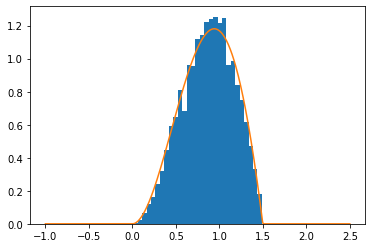

In [40]:
def rejection_sample_uniform(num_samples=100):
    # Generate proposals for samples: these are x-values.
    # We'll keep some and reject the rest.
    proposals = np.random.uniform(low=0, high=1.5, size=num_samples)
    
    # Acceptance probability is the ratio of the two curves
    # This line was incorrect in the version of the notebook
    # used by Prof. Steinhardt in lecture.
    accept_probs = target(proposals) / uniform_sampling_dist(proposals)
    
    print('Max accept prob: %.3f' % np.max(accept_probs))
    
    # For each sample, we make a decision whether or not to accept.
    # Convince yourself that this line makes that decision for each
    # sample with prob equal to the value in "accept_probs"!
    accept = np.random.uniform(size=num_samples) < accept_probs
    num_accept = np.sum(accept)
    print('Accepted %d out of %d proposals' % (num_accept, num_samples))
    return proposals[accept]

samples = rejection_sample_uniform(num_samples=10000)

# Plot a true histogram (comparable with density functions) using density=True
plt.hist(samples, bins=np.linspace(-0.5, 2, 50), density=True)

# Where did this magic number 0.36 come from? What happens if you change it?
plt.plot(x, target(x) / 0.36)
plt.show()

As a final example, what happens if we want to sample across the entire real line? For instance, suppose our density is $p(x) \propto \exp(-x) |\sin(2x)|$ for $x \in [0, \infty)$. We certainly can't use a uniform proposal distribution, but using the exponential distribution works just fine.

Accepted 6099 out of 10000 proposals


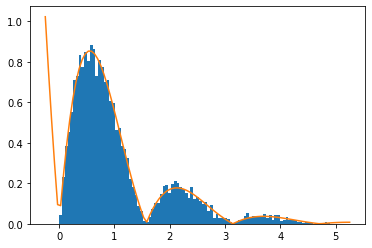

In [37]:
def decaying_target_distribution(x):
    """Unnormalized target distribution as described above"""
    return np.exp(-x) * np.abs(np.sin(2*x))

def sampling_distribution_exponential(x):
    """Sampling distribution: exponential distribution"""
    # stats.expon has a loc parameter which says how far to shift
    # the distribution from its usual starting point of x=0
    return stats.expon.pdf(x, loc=0, scale=1.0)

def rejection_sample_exponential(num_samples=100):
    proposals = np.random.exponential(scale=1.0, size=num_samples)
    
    accept_probs = decaying_target_distribution(proposals) / sampling_distribution_exponential(proposals)
    accept = np.random.uniform(0, 1, num_samples) < accept_probs
    num_accept = np.sum(accept)
    print('Accepted %d out of %d proposals' % (num_accept, num_samples))
    return proposals[accept]
samples = rejection_sample_exponential(num_samples=10000)
plt.hist(samples, bins=np.linspace(0, 5, 100), density=True)
# Find how far the axis goes and draw the unnormalized distribution over it

xmin, xmax, _, _ = plt.axis()
x_inf = np.linspace(xmin, xmax, 100)

# Where did this magic number 0.6 come from? What happens if you change it?
plt.plot(x_inf, decaying_target_distribution(x_inf) / 0.6)
plt.show()